In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Load dataset
df = pd.read_csv("sentimentdataset.csv")

# Clean text
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()                                # lowercase
    text = re.sub(r'[^\w\s]', '', text)                # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # remove extra spaces
    words = [w for w in text.split() if w not in stop_words]  # remove stopwords
    return " ".join(words)

df["Clean_Text"] = df["Text"].apply(clean_text)

In [10]:
# SENTIMENT MAPPING - Apply before any analysis
df['Sentiment_clean'] = df['Sentiment'].str.lower().str.strip()

# Define sentiment groups
negative = [
    'negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'bitter',
    'shame', 'despair', 'grief', 'loneliness', 'jealousy', 'resentment', 'frustration',
    'anxiety', 'helplessness', 'envy', 'regret', 'bitterness',
    'sorrow', 'loss', 'darkness', 'depression', 'fearful', 'heartbreak',
    'apprehensive', 'overwhelmed'
]

neutral = [
    'neutral', 'acceptance', 'calmness', 'indifference', 'contemplation',
    'ambivalence', 'reflection', 'solitude', 'melancholy', 'nostalgia',   'pensive'
]

positive = [
     'amusement', 'enjoyment', 'admiration', 'joy', 'love', 'pride', 'confidence',
    'affection', 'awe', 'hope', 'gratitude', 'contentment', 'serenity',
    'enthusiasm', 'fulfillment', 'positive', 'happiness',  'optimism', 'playful',
    'curiosity', 'excitement', 'kindness', 'friendship', 'success',
    'thrill', 'surprise', 'cheerfulness', 'inspiration', 'freedom', 'blessed', 'satisfaction'
]

# Create mapping function
def map_sentiment(s):
    s = s.lower().strip()
    if s in positive:
        return 2  # positive
    elif s in neutral:
        return 1  # neutral
    elif s in negative:
        return 0  # negative
    else:
        return -1  # unknown

df['label'] = df['Sentiment_clean'].apply(map_sentiment)

# Drop unknown labels
df = df[df['label'] != -1]

print("Sentiment distribution:")
print(df['label'].value_counts())
print("\nLabel mapping: 0=Negative, 1=Neutral, 2=Positive")

Sentiment distribution:
label
2    277
0     98
1     67
Name: count, dtype: int64

Label mapping: 0=Negative, 1=Neutral, 2=Positive


In [11]:
df["Text"]

0       Enjoying a beautiful day at the park!        ...
1       Traffic was terrible this morning.           ...
2       Just finished an amazing workout! 💪          ...
3       Excited about the upcoming weekend getaway!  ...
4       Trying out a new recipe for dinner tonight.  ...
                             ...                        
713    Participating in a science fair to showcase a ...
714    Attending a workshop on time management to enh...
715    Volunteering at a local charity event to give ...
716    Collaborating on a group project to promote te...
717    Participating in a debate club to enhance crit...
Name: Text, Length: 442, dtype: object

In [12]:
df["Clean_Text"]

0                            enjoying beautiful day park
1                               traffic terrible morning
2                               finished amazing workout
3                       excited upcoming weekend getaway
4                       trying new recipe dinner tonight
                             ...                        
713    participating science fair showcase unique exp...
714    attending workshop time management enhance org...
715    volunteering local charity event community con...
716    collaborating group project promote teamwork s...
717    participating debate club enhance critical thi...
Name: Clean_Text, Length: 442, dtype: object

In [13]:
# STEP 1: Additional Imports
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

In [14]:
# Load spacy model
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [15]:
def clean_text_spacy(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() 
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop]
    return " ".join(words)

df["Clean_Text"] = df["Text"].apply(clean_text_spacy)

C:\Users\manta\AppData\Local\Temp\ipykernel_20300\2192429170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Clean_Text"] = df["Text"].apply(clean_text_spacy)


C:\Users\manta\AppData\Local\Temp\ipykernel_20300\2358204260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["POS_Counts"] = df["Clean_Text"].apply(get_pos_counts)


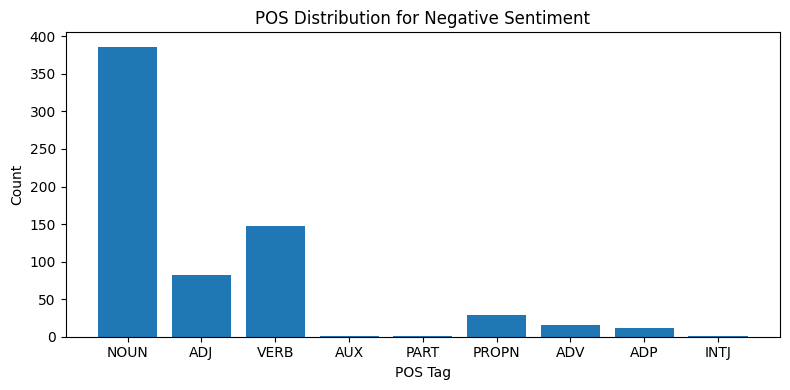

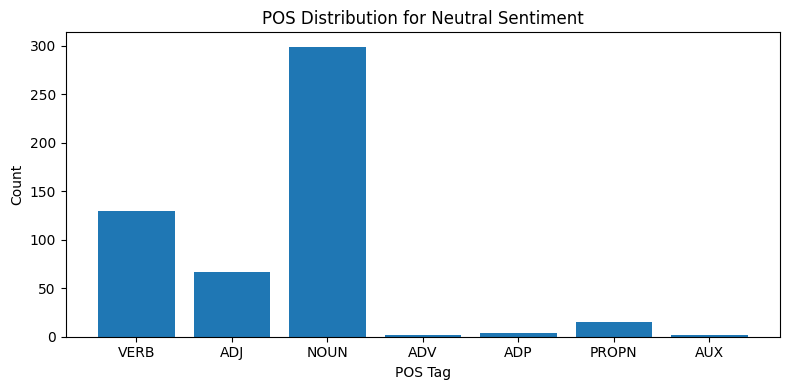

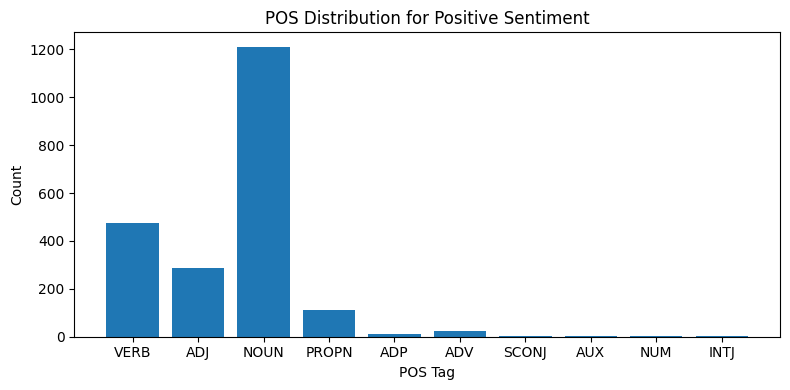

In [16]:
# STEP 2: POS Tagging & Distribution
def get_pos_counts(text):
    doc = nlp(text)
    return Counter([token.pos_ for token in doc])

df["POS_Counts"] = df["Clean_Text"].apply(get_pos_counts)

# Aggregate by sentiment label
sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
pos_by_sentiment = {}
for label in sorted(df["label"].unique()):
    subset = df[df["label"] == label]
    combined = Counter()
    for counts in subset["POS_Counts"]:
        combined.update(counts)
    pos_by_sentiment[sentiment_names[label]] = combined

# Plot POS distribution
for sentiment_name, counts in pos_by_sentiment.items():
    plt.figure(figsize=(8,4))
    plt.bar(counts.keys(), counts.values())
    plt.title(f"POS Distribution for {sentiment_name} Sentiment")
    plt.xlabel("POS Tag")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [17]:
# STEP 3: Lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

df["Lemma_Text"] = df["Clean_Text"].apply(lemmatize_text)

C:\Users\manta\AppData\Local\Temp\ipykernel_20300\3779413959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Lemma_Text"] = df["Clean_Text"].apply(lemmatize_text)


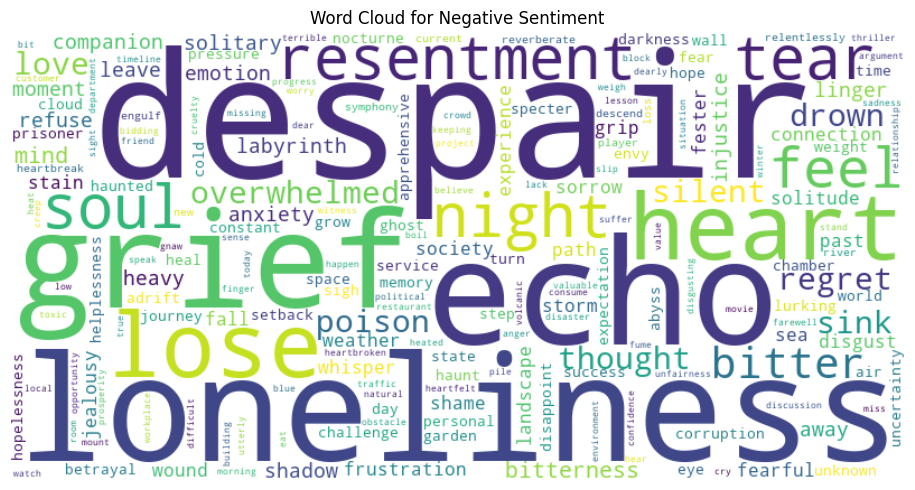

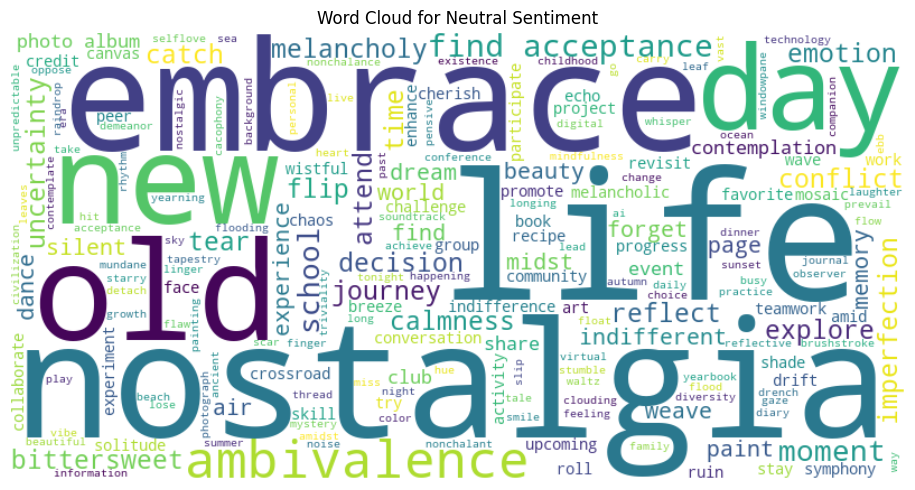

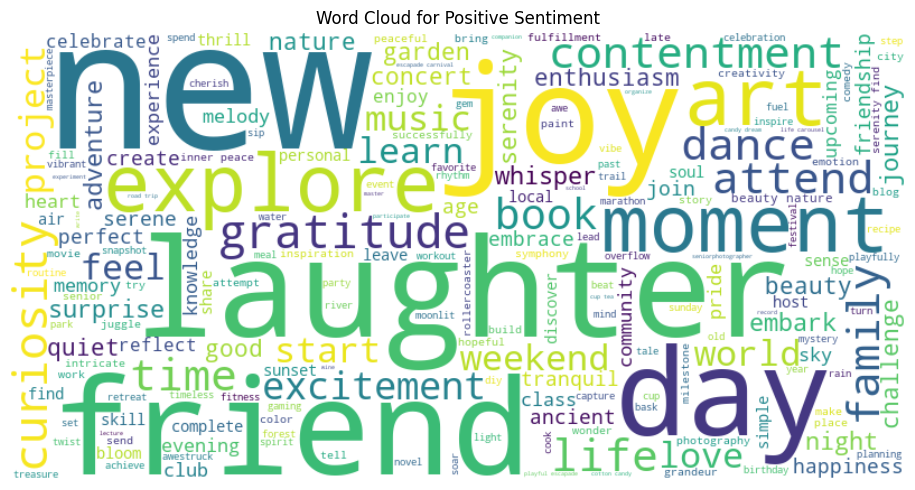

In [18]:
# STEP 4: Word Clouds for each sentiment
sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for label in sorted(df["label"].unique()):
    text = " ".join(df[df["label"] == label]["Lemma_Text"])
    if text.strip():
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {sentiment_names[label]} Sentiment")
        plt.tight_layout()
        plt.show()

In [19]:
# STEP 5: Vectorization (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Lemma_Text"])
y = df["label"]

print(f"TF-IDF matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

TF-IDF matrix shape: (442, 1489)
Number of features: 1489


In [20]:
# STEP 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nTraining set distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\nTest set distribution:\n{pd.Series(y_test).value_counts().sort_index()}")

Training samples: 353
Test samples: 89

Training set distribution:
label
0     78
1     54
2    221
Name: count, dtype: int64

Test set distribution:
label
0    20
1    13
2    56
Name: count, dtype: int64


In [21]:
# STEP 7: Model Training & Evaluation
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print("=" * 50)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

MODEL PERFORMANCE METRICS
Accuracy:  0.6966
Precision: 0.6492
Recall:    0.6966
F1 Score:  0.6107


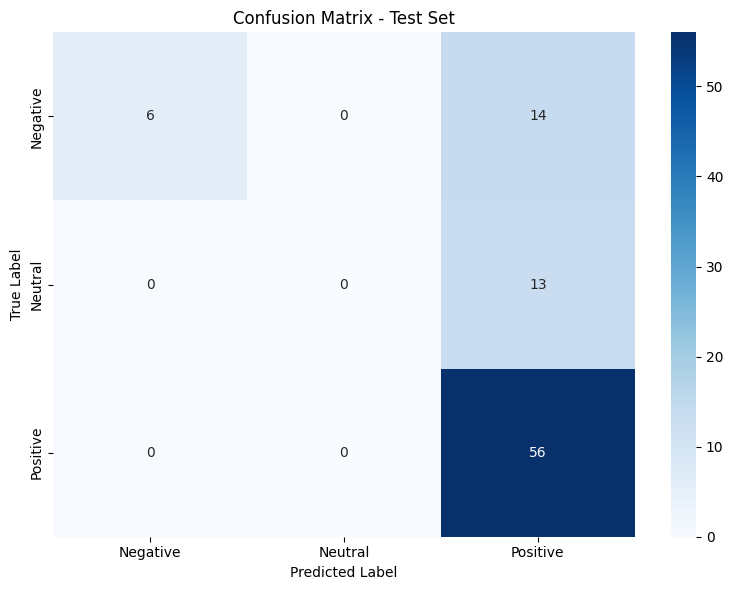


Confusion Matrix:
[[ 6  0 14]
 [ 0  0 13]
 [ 0  0 56]]


In [22]:
# STEP 8: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

In [23]:
# Per-class accuracy
print("\nPer-Class Accuracy on Test Set:")
for idx, sentiment_name in enumerate(['Negative', 'Neutral', 'Positive']):
    mask = (y_test == idx)
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        print(f"{sentiment_name}: {class_acc:.4f} ({np.sum(mask)} samples)")
    else:
        print(f"{sentiment_name}: No test samples")


Per-Class Accuracy on Test Set:
Negative: 0.3000 (20 samples)
Neutral: 0.0000 (13 samples)
Positive: 1.0000 (56 samples)


## Normalized POS Distribution Analysis

In [24]:
# Calculate normalized POS distributions by label
sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
normalized_pos_by_sentiment = {}

print("=" * 60)
print("NORMALIZED POS DISTRIBUTION (as percentage of total POS per label)")
print("=" * 60)

for label in sorted(df["label"].unique()):
    subset = df[df["label"] == label]
    combined = Counter()
    
    # Count all POS tags for this label
    for counts in subset["POS_Counts"]:
        combined.update(counts)
    
    # Calculate total POS count for normalization
    total_pos_count = sum(combined.values())
    
    # Normalize: divide each count by total
    normalized = {pos: (count / total_pos_count * 100) for pos, count in combined.items()}
    normalized_pos_by_sentiment[sentiment_names[label]] = normalized
    
    # Sort by percentage and print
    sorted_pos = sorted(normalized.items(), key=lambda x: x[1], reverse=True)
    print(f"\n{sentiment_names[label]} ({total_pos_count} total POS tags):")
    print("-" * 60)
    for pos, percentage in sorted_pos:
        print(f"  {pos:8s}: {percentage:6.2f}%")


NORMALIZED POS DISTRIBUTION (as percentage of total POS per label)

Negative (674 total POS tags):
------------------------------------------------------------
  NOUN    :  57.27%
  VERB    :  21.81%
  ADJ     :  12.17%
  PROPN   :   4.30%
  ADV     :   2.23%
  ADP     :   1.78%
  AUX     :   0.15%
  PART    :   0.15%
  INTJ    :   0.15%

Neutral (519 total POS tags):
------------------------------------------------------------
  NOUN    :  57.61%
  VERB    :  25.05%
  ADJ     :  12.91%
  PROPN   :   2.89%
  ADP     :   0.77%
  ADV     :   0.39%
  AUX     :   0.39%

Positive (2133 total POS tags):
------------------------------------------------------------
  NOUN    :  56.77%
  VERB    :  22.36%
  ADJ     :  13.55%
  PROPN   :   5.25%
  ADV     :   1.08%
  ADP     :   0.61%
  NUM     :   0.19%
  AUX     :   0.09%
  SCONJ   :   0.05%
  INTJ    :   0.05%


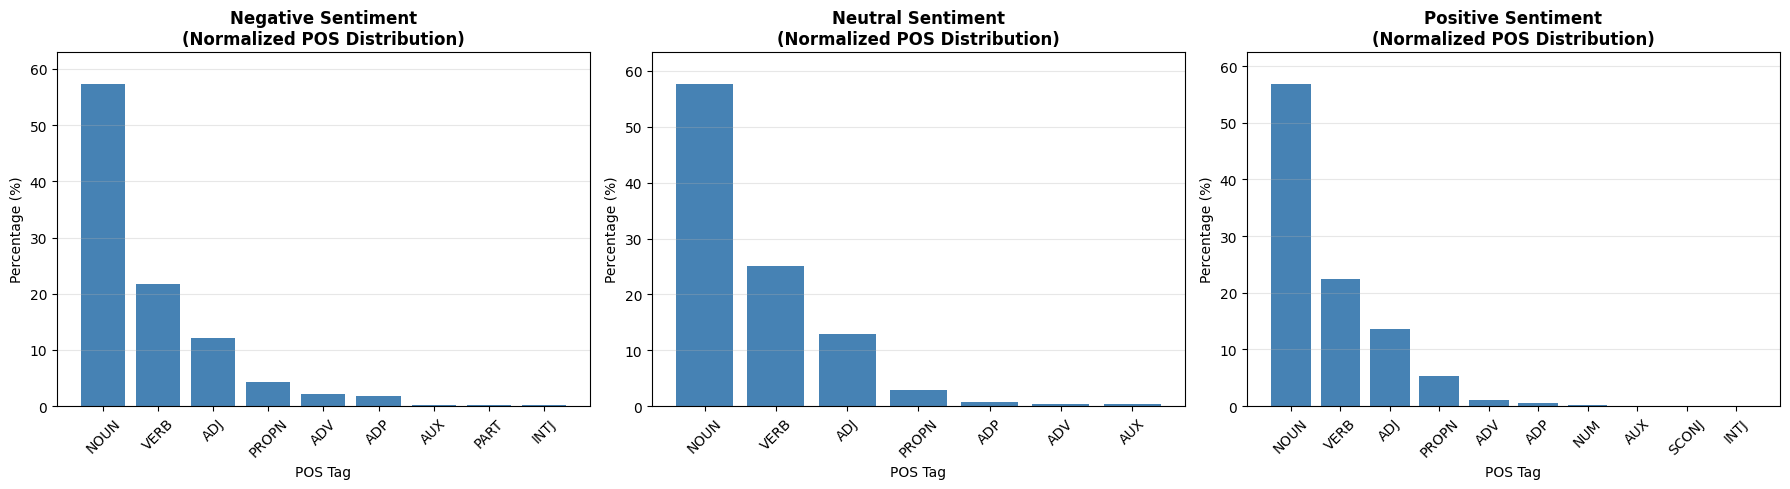

In [25]:
# Plot normalized POS distributions as ordered histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (sentiment_name, normalized_dist) in enumerate(sorted(normalized_pos_by_sentiment.items())):
    # Sort by percentage (descending)
    sorted_dist = dict(sorted(normalized_dist.items(), key=lambda x: x[1], reverse=True))
    
    pos_tags = list(sorted_dist.keys())
    percentages = list(sorted_dist.values())
    
    # Create bar chart
    axes[idx].bar(pos_tags, percentages, color='steelblue')
    axes[idx].set_title(f'{sentiment_name} Sentiment\n(Normalized POS Distribution)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].set_xlabel('POS Tag')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, max(percentages) * 1.1)
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



COMPARATIVE NORMALIZED POS DISTRIBUTION (Percentage)
       Negative  Neutral  Positive
ADJ       12.17    12.91     13.55
ADP        1.78     0.77      0.61
ADV        2.23     0.39      1.08
AUX        0.15     0.39      0.09
INTJ       0.15     0.00      0.05
NOUN      57.27    57.61     56.77
NUM        0.00     0.00      0.19
PART       0.15     0.00      0.00
PROPN      4.30     2.89      5.25
SCONJ      0.00     0.00      0.05
VERB      21.81    25.05     22.36


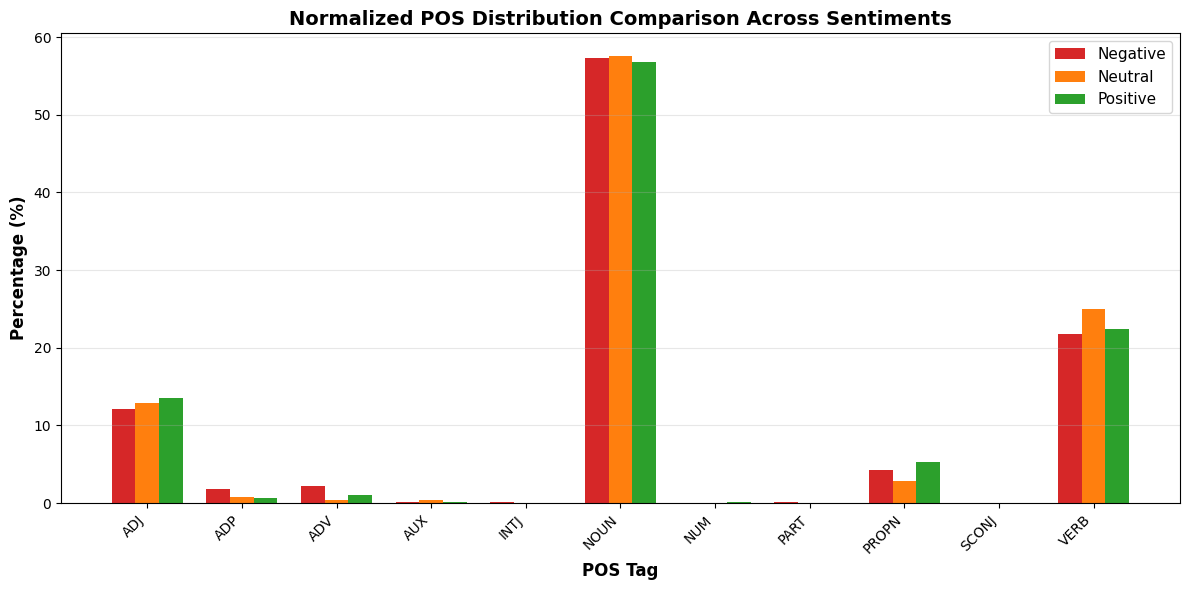

In [26]:
# Comparative view: All POS tags side-by-side with normalized values
all_pos_tags = set()
for dist in normalized_pos_by_sentiment.values():
    all_pos_tags.update(dist.keys())

all_pos_tags = sorted(list(all_pos_tags))

# Create comparison dataframe
comparison_data = {}
for sentiment_name in ['Negative', 'Neutral', 'Positive']:
    comparison_data[sentiment_name] = [
        normalized_pos_by_sentiment[sentiment_name].get(pos, 0) for pos in all_pos_tags
    ]

comparison_df = pd.DataFrame(comparison_data, index=all_pos_tags)

print("\n" + "=" * 80)
print("COMPARATIVE NORMALIZED POS DISTRIBUTION (Percentage)")
print("=" * 80)
print(comparison_df.round(2))
print("=" * 80)

# Plot grouped bar chart for easy comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(all_pos_tags))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Negative'], width, label='Negative', color='#d62728')
bars2 = ax.bar(x, comparison_df['Neutral'], width, label='Neutral', color='#ff7f0e')
bars3 = ax.bar(x + width, comparison_df['Positive'], width, label='Positive', color='#2ca02c')

ax.set_xlabel('POS Tag', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized POS Distribution Comparison Across Sentiments', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_pos_tags, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
# Additional analysis: Show differences between sentiments
print("\n" + "=" * 80)
print("POS DIFFERENCES BETWEEN SENTIMENTS")
print("=" * 80)

# Which POS tags are most characteristic of each sentiment?
for sentiment in ['Negative', 'Neutral', 'Positive']:
    other_sentiments = [s for s in ['Negative', 'Neutral', 'Positive'] if s != sentiment]
    
    # Calculate average difference from other sentiments
    differences = {}
    for pos in all_pos_tags:
        current_val = comparison_df.loc[pos, sentiment]
        other_avg = comparison_df.loc[pos, other_sentiments].mean()
        differences[pos] = current_val - other_avg
    
    # Sort and show top 5
    sorted_diff = sorted(differences.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nMost characteristic POS tags for {sentiment}:")
    print("-" * 40)
    for pos, diff in sorted_diff[:5]:
        val = comparison_df.loc[pos, sentiment]
        print(f"  {pos:8s}: {val:6.2f}% (diff: +{diff:6.2f}%)")



POS DIFFERENCES BETWEEN SENTIMENTS

Most characteristic POS tags for Negative:
----------------------------------------
  ADV     :   2.23% (diff: +  1.49%)
  ADP     :   1.78% (diff: +  1.09%)
  PROPN   :   4.30% (diff: +  0.23%)
  PART    :   0.15% (diff: +  0.15%)
  INTJ    :   0.15% (diff: +  0.12%)

Most characteristic POS tags for Neutral:
----------------------------------------
  VERB    :  25.05% (diff: +  2.96%)
  NOUN    :  57.61% (diff: +  0.59%)
  AUX     :   0.39% (diff: +  0.26%)
  ADJ     :  12.91% (diff: +  0.05%)
  SCONJ   :   0.00% (diff: + -0.02%)

Most characteristic POS tags for Positive:
----------------------------------------
  PROPN   :   5.25% (diff: +  1.65%)
  ADJ     :  13.55% (diff: +  1.01%)
  NUM     :   0.19% (diff: +  0.19%)
  SCONJ   :   0.05% (diff: +  0.05%)
  INTJ    :   0.05% (diff: + -0.03%)


## Binary Classification: Positive vs Negative Only

In [28]:
# Create binary classification dataset (only Positive and Negative)
df_binary = df[df['label'] != 1].copy()  # Remove neutral (label 1)
df_binary['label'] = df_binary['label'].map({0: 0, 2: 1})  # Map: Negative=0, Positive=1

print("Binary Classification Dataset:")
print(f"Original dataset size: {len(df)}")
print(f"Binary dataset size (Positive + Negative): {len(df_binary)}")
print(f"\nBinary label distribution:\n{df_binary['label'].value_counts().sort_index()}")
print(f"\nLabel mapping: 0=Negative, 1=Positive")


Binary Classification Dataset:
Original dataset size: 442
Binary dataset size (Positive + Negative): 375

Binary label distribution:
label
0     98
1    277
Name: count, dtype: int64

Label mapping: 0=Negative, 1=Positive


In [29]:
# Binary Vectorization (TF-IDF)
vectorizer_binary = TfidfVectorizer(max_features=5000)
X_binary = vectorizer_binary.fit_transform(df_binary["Lemma_Text"])
y_binary = df_binary["label"]

print(f"Binary TF-IDF matrix shape: {X_binary.shape}")
print(f"Number of features: {X_binary.shape[1]}")


Binary TF-IDF matrix shape: (375, 1341)
Number of features: 1341


In [30]:
# Binary Train-Test Split
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Binary Training samples: {X_train_binary.shape[0]}")
print(f"Binary Test samples: {X_test_binary.shape[0]}")
print(f"\nBinary Training set distribution:\n{pd.Series(y_train_binary).value_counts().sort_index()}")
print(f"\nBinary Test set distribution:\n{pd.Series(y_test_binary).value_counts().sort_index()}")


Binary Training samples: 300
Binary Test samples: 75

Binary Training set distribution:
label
0     78
1    222
Name: count, dtype: int64

Binary Test set distribution:
label
0    20
1    55
Name: count, dtype: int64


In [31]:
# Binary Model Training & Evaluation
model_binary = MultinomialNB()
model_binary.fit(X_train_binary, y_train_binary)

y_pred_binary = model_binary.predict(X_test_binary)

print("=" * 50)
print("BINARY MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test_binary, y_pred_binary):.4f}")
print(f"Precision: {precision_score(y_test_binary, y_pred_binary, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_binary, y_pred_binary, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_binary, y_pred_binary, zero_division=0):.4f}")
print("=" * 50)
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Negative', 'Positive'], zero_division=0))


BINARY MODEL PERFORMANCE METRICS
Accuracy:  0.8400
Precision: 0.8209
Recall:    1.0000
F1 Score:  0.9016

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.40      0.57        20
    Positive       0.82      1.00      0.90        55

    accuracy                           0.84        75
   macro avg       0.91      0.70      0.74        75
weighted avg       0.87      0.84      0.81        75



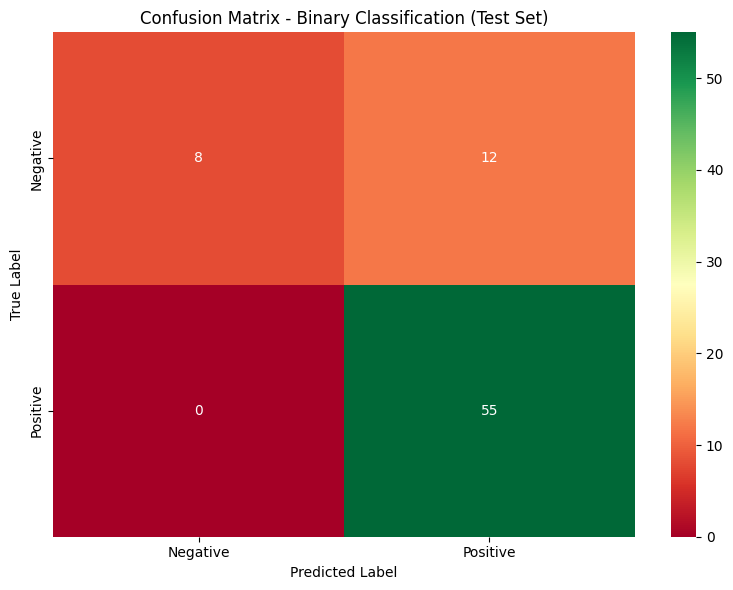


Binary Confusion Matrix:
[[ 8 12]
 [ 0 55]]

Breakdown:
True Negatives (TN): 8
False Positives (FP): 12
False Negatives (FN): 0
True Positives (TP): 55


In [32]:
# Binary Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Binary Classification (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nBinary Confusion Matrix:")
print(cm_binary)
print("\nBreakdown:")
print(f"True Negatives (TN): {cm_binary[0, 0]}")
print(f"False Positives (FP): {cm_binary[0, 1]}")
print(f"False Negatives (FN): {cm_binary[1, 0]}")
print(f"True Positives (TP): {cm_binary[1, 1]}")


In [33]:
# Binary Model Predictions with Confidence Scores
y_pred_proba_binary = model_binary.predict_proba(X_test_binary)

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'True_Label': ['Negative' if y == 0 else 'Positive' for y in y_test_binary],
    'Predicted_Label': ['Negative' if y == 0 else 'Positive' for y in y_pred_binary],
    'Confidence_Negative': y_pred_proba_binary[:, 0],
    'Confidence_Positive': y_pred_proba_binary[:, 1],
    'Prediction_Correct': y_pred_binary == y_test_binary
})

print("\n" + "=" * 100)
print("BINARY MODEL PREDICTIONS (First 20 samples)")
print("=" * 100)
print(predictions_df.head(20).to_string())

print("\n" + "=" * 100)
print("PREDICTION SUMMARY")
print("=" * 100)
print(f"Total Correct: {predictions_df['Prediction_Correct'].sum()}/{len(predictions_df)}")
print(f"Total Incorrect: {(~predictions_df['Prediction_Correct']).sum()}/{len(predictions_df)}")
print(f"\nAccuracy: {predictions_df['Prediction_Correct'].sum() / len(predictions_df):.4f}")

# Per-class accuracy
print(f"\nNegative Accuracy: {predictions_df[(predictions_df['True_Label'] == 'Negative') & (predictions_df['Prediction_Correct'])].shape[0] / (predictions_df['True_Label'] == 'Negative').sum():.4f}")
print(f"Positive Accuracy: {predictions_df[(predictions_df['True_Label'] == 'Positive') & (predictions_df['Prediction_Correct'])].shape[0] / (predictions_df['True_Label'] == 'Positive').sum():.4f}")



BINARY MODEL PREDICTIONS (First 20 samples)
    True_Label Predicted_Label  Confidence_Negative  Confidence_Positive  Prediction_Correct
49    Positive        Positive             0.289732             0.710268                True
163   Negative        Negative             0.535587             0.464413                True
608   Positive        Positive             0.091234             0.908766                True
112   Positive        Positive             0.168759             0.831241                True
164   Negative        Positive             0.485129             0.514871               False
436   Negative        Positive             0.360910             0.639090               False
658   Positive        Positive             0.121569             0.878431                True
641   Positive        Positive             0.310422             0.689578                True
11    Negative        Positive             0.364818             0.635182               False
384   Positive        Pos